In [2]:
##필요한 패키지 등록'
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
'''##데이터 불러오기
dir_data = './EMdataset'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames'''

In [4]:
'''## train, test, validation set 나누기
nframe_train = 24
nframe_val = 3
nframe_test = 3 

dir_save_train = os.path.join(dir_data, 'train') #train data가 저장될 디렉토리
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

#ditectoty generate
if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)
    
if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)
    
if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)    '''

In [5]:
'''## 생성한 디렉토리에 데이터셋 나누어 저장하기
# random index
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)'''

In [8]:
'''#dataset separate
offset_nframe = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])
    
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)
    
    np.save(os.path.join(dir_save_train, 'label_%03d.npy' %i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' %i), input_)'''

In [9]:
'''offset_nframe += nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])
    
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)
    
    np.save(os.path.join(dir_save_val, 'label_%03d.npy' %i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' %i), input_)'''

In [10]:
'''offset_nframe += nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])
    
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)
    
    np.save(os.path.join(dir_save_test, 'label_%03d.npy' %i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' %i), input_)'''

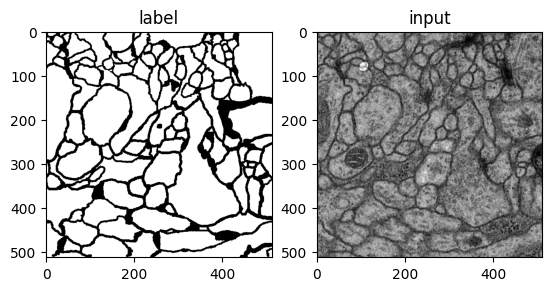

In [11]:
##생성한 데이터 출력하기
plt.subplot(121)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_, cmap='gray')
plt. title('input')

plt.show()

In [12]:
##U-net 네트워크 구현하기 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets

In [13]:
##트레이닝 하이퍼 파라메터 설정하기
lr = 1e-3
batch_size = 4
num_epoch = 100

#트레이닝 정보를 저장할 디렉토리
data_dir = './EMdataset'
ckpt_dir = './checkpoint'
log_dir = './log'

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [82]:
##네트워크 구축하기
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        def CBR2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            
            layers += [nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                bias=bias)]
            
            layers += [nn.BatchNorm2d(num_features = out_channel)]
            
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            return cbr
        
        #Encoder part
        self.enc1_1 = CBR2d(in_channel=1, out_channel=64) 
        self.enc1_2 = CBR2d(in_channel=64, out_channel=64)
        
        self.pool1 = nn.MaxPool2d(kernel_size =2) # image shape 1/2 #
        
        self.enc2_1 = CBR2d(in_channel=64, out_channel=128)
        self.enc2_2 = CBR2d(in_channel=128, out_channel=128)
        
        self.pool2 = nn.MaxPool2d(kernel_size =2) # image shape 1/2 #
        
        self.enc3_1 = CBR2d(in_channel=128, out_channel=256)
        self.enc3_2 = CBR2d(in_channel=256, out_channel=256)
        
        self.pool3 = nn.MaxPool2d(kernel_size =2) # image shape 1/2 #
        
        self.enc4_1 = CBR2d(in_channel=256, out_channel=512)
        self.enc4_2 = CBR2d(in_channel=512, out_channel=512)
        
        self.pool4 = nn.MaxPool2d(kernel_size =2) # image shape 1/2 #
        
        self.enc5 = CBR2d(in_channel=512, out_channel=1024)
        
        #Decoder part
        self.dec5 = CBR2d(in_channel=1024, out_channel=512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                         kernel_size=2, stride=2, padding=0, bias=True) # image shape *2 #
        
        self.dec4_2 = CBR2d(in_channel=2*512, out_channel = 512)
        self.dec4_1 = CBR2d(in_channel=512, out_channel = 256)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                         kernel_size=2, stride=2, padding=0, bias=True) # image shape *2 #
        
        self.dec3_2 = CBR2d(in_channel=2*256, out_channel = 256)
        self.dec3_1 = CBR2d(in_channel=256, out_channel = 128)
        
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                         kernel_size=2, stride=2, padding=0, bias=True) # image shape *2 #
        
        self.dec2_2 = CBR2d(in_channel=2*128, out_channel = 128)
        self.dec2_1 = CBR2d(in_channel=128, out_channel = 64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                         kernel_size=2, stride=2, padding=0, bias=True) # image shape *2 #
        
        self.dec1_2 = CBR2d(in_channel=2*64, out_channel = 64)
        self.dec1_1 = CBR2d(in_channel=64, out_channel = 64)
        
        #n개의 클래스를 갖는 출력을 만들어주기 위해 1*1 conv
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        
        def forward(self, x):
            enc1_1 = self.enc1_1(x)
            enc1_2 = self.enc1_2(enc1_1)
            pool1 = self.pool1(enc1_2)
            
            enc2_1 = self.enc2_1(pool1)
            enc2_2 = self.enc2_2(enc2_1)
            pool2 = self.pool2(enc2_2)
            
            enc3_1 = self.enc3_1(pool2)
            enc3_2 = self.enc3_2(enc3_1)
            pool3 = self.pool3(enc3_2)
            
            enc4_1 = self.enc4_1(pool3)
            enc4_2 = self.enc4_2(enc4_1)
            pool4 = self.pool4(enc4_2)
            
            enc5 = self.enc5(pool4)
            
            dec5 = self.dec5(enc5)
            
            unpool4 = self.unpool3(dec5)
            cat4 = torch.cat((unpool4, enc4_2), dim=1)
            dec4_2 = self.dec4_2(cat4)
            dec4_1 = self.dec4_1(dec4_2)
            
            unpool3 = self.unpool3(dec4_1)
            cat3 = torch.cat((unpool3, enc3_2), dim=1)
            dec3_2 = self.dec3_2(cat3)
            dec3_1 = self.dec3_1(dec3_2)
            
            unpool2 = self.unpool2(dec3_1)
            cat2 = torch.cat((unpool2, enc2_2), dim=1)
            dec2_2 = self.dec2_2(cat2)
            dec2_1 = self.dec2_1(dec2_2)
            
            unpool1 = self.unpool1(dec2_1)
            cat1 = torch.cat((unpool1, enc1_2), dim=1)
            dec1_2 = self.dec1_2(cat1)
            dec1_1 = self.dec1_1(dec1_2)
            
            x = self.fc(dec1_1)
            
            return x

In [18]:
#데이터 로더 구현 
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        label = label/255.0
        input = input/255.0

        # making channel dimension 
        if label.ndim == 2:
            label = label[:, : , np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data



In [38]:
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'))

In [39]:
data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']

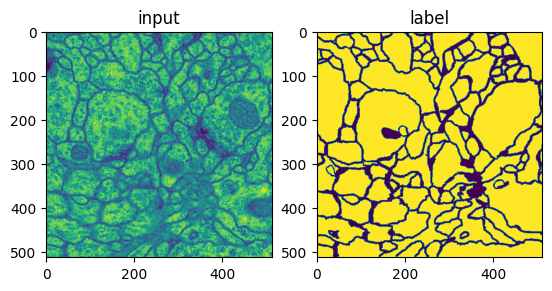

In [24]:
plt.subplot(121)
plt.imshow(input)
plt.title('input')

plt.subplot(122)
plt.imshow(label)
plt.title('label')

plt.show()

In [57]:
##Transform implemation
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean = 0.5, std = 0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std
        #label은 0 or 1로 되어있지 때문에 해주지 않아

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() < 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input':input}

        return data





In [58]:
transform = transforms.Compose([Normalization(mean=0.5, std= 0.5), 
                                RandomFlip(), 
                                ToTensor()])


In [59]:
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)

In [67]:
data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']

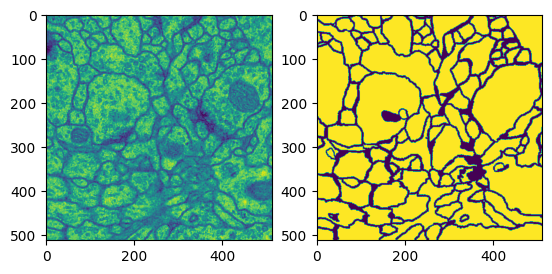

In [74]:
plt.subplot(121)
plt.imshow(input.squeeze())

plt.subplot(122)
plt.imshow(label.squeeze())

plt.show()

In [86]:
#training
    #data load
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size = 4, shuffle=False, num_workers= 8 )

    ##network
net = Unet().to(device)

    ##define loss function
fn_loss = nn.BCEWithLogitsLoss().to(device)

    ## set optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr)


num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm =  lambda x, mean, std: (x*sed)+mean
fn_class = lambda x: 1.0 * (x > 0.5)

#Tensorboard를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

#네트워크 저장
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()}, "./s%/model_epoch%d.pth" % (ckpt_dir, epoch))

#네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key = lambda f: int("".join(filter(str.isdigit, f))))

    dict_model = torch.load('./%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

##training for loop
st_epoch = 0
net, optimm, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim= optim)


for epoch in range(st_epoch +1, num_epoch +1):
    net.train()
    loss_arr = []

    for batch, data in enumerate(loader_train, 1):
        #forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)

        output = net(input)

        #backward pass
        optim.zero_grad()

        loss = fn_loss(output, label)
        loss.backward()

        optim.step()

        #손실함수 계산
        loss_arr += [loss.item()]

        print('Train: Epoch %04d / %04d | Batch %04d / %04d | Loss %.4f' % 
        (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

        #Tensorboard에 input, output, label 저장
        label = fn_tonumpy(label)
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        writer_train.add_image('label', label, num_batch_train * (epoch -1) + batch, dataformats='NHWC')
        writer_train.add_image('input', input, num_batch_train * (epoch -1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_batch_train * (epoch -1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

    #validation loop
    with torch.no_grad():
        net.eval()
        loss_arr = []

        for batch, data in enumerate(loader_val, 1):
            #forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            loss = fn_loss(output, label)
            loss_arr += [loss.item()]

            print('Train: Epoch %04d / %04d | Batch %04d / %04d | Loss %.4f' % 
            (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input))
            output = fn_tonumpy(fn_class(output))

            writer_val.add_image('label', label, num_batch_val * (epoch -1) + batch, dataformats='NHWC')
            writer_val.add_image('input', input, num_batch_val * (epoch -1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_batch_val * (epoch -1) + batch, dataformats='NHWC')

    writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

    if epoch % 10 ==0:
        save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)


writer_train.close()
writer_val.close()




Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_parent)
           ^^Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'Dataset' on <module '__main__' (built-in)>
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.p

RuntimeError: DataLoader worker (pid(s) 57088, 57089, 57090) exited unexpectedly